In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import gdown
import h5py
import cv2
import numpy as np
import os


/home/carl_ma/miniconda3/envs/robodiff/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# generate visible dataset
# Path to your demo HDF5 file
demo_file = "dataset/demo_duck_feb12.hdf5"
output_directory = "visible_object"  # Folder to save images
os.makedirs(output_directory, exist_ok=True)  # Create directory if it doesn't exist

# List to hold all visible images across demos
visible_images_list = []

# Open the HDF5 file and extract the "eye_in_hand_rgb" images
with h5py.File(demo_file, "r") as f:
    demo_keys = list(f["data"].keys())
    print("Available Demos:", demo_keys)
    
    image_counter = 0  # Counter to name images uniquely
    
    for demo_name in demo_keys:
        demo_data = f["data"][demo_name]
        obs_group = demo_data["obs"]
        
        if "eye_in_hand_rgb" in obs_group:
            # Extract the images for this demo (assumed shape: [T, H, W, C])
            images = obs_group["eye_in_hand_rgb"][:]  # Shape: (T, H, W, C)
            
            for i, img in enumerate(images):
                # Convert from float [0, 1] to uint8 [0, 255] if needed
                if img.dtype in [np.float32, np.float64]:
                    img = (img * 255).astype(np.uint8)
                
                # Convert RGB to BGR (OpenCV default)
                img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

                # Save the image
                img_filename = os.path.join(output_directory, f"image_{image_counter:05d}.png")
                cv2.imwrite(img_filename, img_bgr)
                image_counter += 1

print(f"Saved {image_counter} images in '{output_directory}'.")


Available Demos: ['demo_0', 'demo_1', 'demo_2', 'demo_3', 'demo_4', 'demo_5']
Saved 1743 images in 'visible_object'.


In [ ]:
# generate not visible dataset

# Path to your demo HDF5 file (not visible or background)
demo_file = "" # update this
output_directory = "not_visible"  # Folder to save images
os.makedirs(output_directory, exist_ok=True)  # Create directory if it doesn't exist

# List to hold all visible images across demos
visible_images_list = []

# Open the HDF5 file and extract the "eye_in_hand_rgb" images
with h5py.File(demo_file, "r") as f:
    demo_keys = list(f["data"].keys())
    print("Available Demos:", demo_keys)
    
    image_counter = 0  # Counter to name images uniquely
    
    for demo_name in demo_keys:
        demo_data = f["data"][demo_name]
        obs_group = demo_data["obs"]
        
        if "eye_in_hand_rgb" in obs_group:
            # Extract the images for this demo (assumed shape: [T, H, W, C])
            images = obs_group["eye_in_hand_rgb"][:]  # Shape: (T, H, W, C)
            
            for i, img in enumerate(images):
                # Convert from float [0, 1] to uint8 [0, 255] if needed
                if img.dtype in [np.float32, np.float64]:
                    img = (img * 255).astype(np.uint8)
                
                # Convert RGB to BGR (OpenCV default)
                img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

                # Save the image
                img_filename = os.path.join(output_directory, f"image_{image_counter:05d}.png")
                cv2.imwrite(img_filename, img_bgr)
                image_counter += 1

print(f"Saved {image_counter} images in '{output_directory}'.")

Total background images read: 210


In [3]:
# Define the Vision Encoder with Spatial Softmax Pooling and GroupNorm
def get_modified_resnet(name: str, weights=None) -> nn.Module:
    resnet = getattr(models, name)(weights=weights)

    # Create a list of modules to be replaced first
    modules_to_replace = []
    for name, module in resnet.named_modules():
        if isinstance(module, nn.BatchNorm2d):
            modules_to_replace.append((name, module))

    # Now iterate over the collected modules and replace them
    for name, module in modules_to_replace:
        setattr(resnet, name, nn.GroupNorm(num_groups=32, num_channels=module.num_features))

    # Replace Global Average Pooling with Spatial Softmax Pooling
    resnet.avgpool = nn.Sequential(
        nn.Flatten(start_dim=2),
        nn.Softmax(dim=2),
        nn.Flatten(start_dim=1)
    )

    resnet.fc = torch.nn.Identity()  # Remove final FC layer
    return resnet

In [ ]:
load_pretrained = True
if load_pretrained:
  ckpt_path = "pusht_vision_100ep.ckpt"
  if not os.path.isfile(ckpt_path):
      id = "1XKpfNSlwYMGaF5CncoFaLKCDTWoLAHf1&confirm=t"
      gdown.download(id=id, output=ckpt_path, quiet=False)

In [4]:
# Load trained vision encoder
vision_encoder = get_modified_resnet('resnet18', weights=None)

# Load the trained weights
ckpt_path = "/home/carl_ma/Riad/diffusion_policy/data/outputs/custom2025_02_20_14_10_11/checkpoints/epoch_500_20250220_162513.ckpt"
if os.path.isfile(ckpt_path):
    state_dict = torch.load(ckpt_path, map_location='cuda')

    # Remove 'vision_encoder.' prefix from state_dict keys
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith("vision_encoder."):
            new_state_dict[k[len("vision_encoder."):]] = v
        else:
            new_state_dict[k] = v

    # Load the modified state_dict with strict=False
    vision_encoder.load_state_dict(new_state_dict, strict=False)
    print("Loaded trained weights successfully.")
else:
    print("Checkpoint not found. Using default weights.")

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vision_encoder.to(device)
vision_encoder.eval()

Loaded trained weights successfully.


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): GroupNorm(32, 64, eps=1e-05, affine=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_siz

In [ ]:
# Define dataset class
class ObjectVisibilityDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []

        visible_dir = os.path.join(root_dir, "visible_object")
        not_visible_dir = os.path.join(root_dir, "a_background") # update this

        for img_name in os.listdir(visible_dir):
            self.data.append((os.path.join(visible_dir, img_name), 1))  # Label 1 for visible

        for img_name in os.listdir(not_visible_dir):
            self.data.append((os.path.join(not_visible_dir, img_name), 0))  # Label 0 for not visible

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)


In [6]:
# Define transformation
transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor()
])

# Create dataset and dataloader
root_dir = "."
dataset = ObjectVisibilityDataset(root_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [7]:
def extract_features(image_tensor):
    """Extract object features using the trained vision encoder."""
    image_tensor = image_tensor.to(device)  # Ensure input is on the same device

    with torch.no_grad():
        features = vision_encoder(image_tensor)  # Output shape: (Batch, 512)
    return features

In [9]:
import torch.nn as nn

# Define the Classifier Head
class ClassifierHead(nn.Module):
    def __init__(self, feature_dim=4608, num_classes=2):  # Ensure feature_dim matches the input
        super(ClassifierHead, self).__init__()
        self.fc = nn.Linear(feature_dim, num_classes)  # Direct classifier head

    def forward(self, features):
        return self.fc(features)  # No extra layers

# Example Usage:
# Assuming `features` is extracted from a backbone model
classifier_head = ClassifierHead(feature_dim=4608, num_classes=2).to(device)



# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier_head.parameters(), lr=1e-4)


In [12]:
def train_object_detector(dataloader, num_epochs=10):
    classifier_head.train()
    for epoch in range(num_epochs):
        total_loss = 0.0
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            features = extract_features(images)
            outputs = classifier_head(features)

            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataloader):.4f}")
    print("Training Complete.")

In [13]:
# Train the model
train_object_detector(dataloader)

Epoch [1/10], Loss: 0.3595
Epoch [2/10], Loss: 0.2663
Epoch [3/10], Loss: 0.2231
Epoch [4/10], Loss: 0.1852
Epoch [5/10], Loss: 0.1582
Epoch [6/10], Loss: 0.1366
Epoch [7/10], Loss: 0.1198
Epoch [8/10], Loss: 0.1069
Epoch [9/10], Loss: 0.0972
Epoch [10/10], Loss: 0.0876
Training Complete.


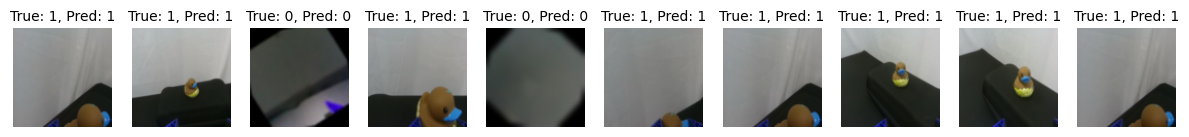

In [23]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def predict_object_detector(dataloader, num_samples=10):
    classifier_head.eval()  # Set to evaluation mode
    images_list, labels_list, predictions_list = [], [], []

    with torch.no_grad():  # No gradient computation for inference
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            features = extract_features(images)  # Extract features from backbone
            outputs = classifier_head(features)  # Get predictions

            # Convert logits to probabilities
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)  # Get predicted class index

            # Store for visualization
            images_list.extend(images[:num_samples].cpu())  # Convert to CPU for plotting
            labels_list.extend(labels[:num_samples].cpu())
            predictions_list.extend(preds[:num_samples].cpu())

            if len(images_list) >= num_samples:
                break  # Stop after collecting enough samples

    # Plot sample predictions
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        img = images_list[i].permute(1, 2, 0).numpy()  # Convert to (H, W, C)
        label = labels_list[i].item()
        pred = predictions_list[i].item()
        
        axes[i].imshow(img)
        axes[i].set_title(f"True: {label}, Pred: {pred}", fontsize=10)
        axes[i].axis("off")

    plt.show()

# Example usage after training:
predict_object_detector(dataloader, num_samples=10)
